In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.conv_learner import *
from fastai.text import *

#from warpctc_pytorch import CTCLoss

In [3]:
PATH = Path('data/IAM_handwriting')
TMP_PATH = PATH/'tmp'

In [4]:
!ls {PATH}

20_words.csv  line_labels.csv  models		  word_labels.csv  words.csv
ascii	      lines	       tmp		  words		   words.tgz
chars.csv     lines.tgz        word_char_ids.csv  words_chars.csv


In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Synthetic Data

### images

In [6]:
os.makedirs(PATH/'synth_words', exist_ok=True)

In [7]:
def create_img(files, fname):
    imgs    = [ PIL.Image.open(PATH/'words'/f) for f in files ]
    widths, heights = zip(*(i.size for i in imgs))

    total_height = sum(heights)
    max_width = max(widths)

    new_im = Image.new('RGB', (max_width, total_height), color=(255,255,255))

    y_offset = 0
    for im in imgs:
      new_im.paste(im, (0,y_offset))
      y_offset += im.size[1]

    new_im.save(PATH/'synth_words'/fname)

### labels

In [8]:
maxTextLen = 32
samples = []
chars = set()

f=open(f'{PATH}/ascii/words.txt')
for line in f:
    # ignore comment line
    if not line or line[0]=='#':
        continue

    lineSplit = line.strip().split(' ')
    assert len(lineSplit) >= 9

    fileName = lineSplit[0]

    # GT text are columns starting at 9
    gtText = ''.join(lineSplit[8:])[:maxTextLen]
    char_len = len(gtText)
    chars = chars.union(set(list(gtText)))

    # put sample into list
    samples.append([fileName, gtText, char_len])
    
data = np.stack(samples)
df = pd.DataFrame(data, columns=['filename', 'word', 'char_len'], )
df.head()

,filename,word,char_len
0,a01-000u-00-00,A,1
1,a01-000u-00-01,MOVE,4
2,a01-000u-00-02,to,2
3,a01-000u-00-03,stop,4
4,a01-000u-00-04,Mr.,3


### Create Data

In [9]:
df['char_len'] = df.char_len.astype('int32')
gt3 = df.loc[df['char_len'] > 3]

In [10]:
def create_synth_data(num):
    d={}
    for i in range(num):
        res = gt3.sample(3)
        files = list(map(lambda x: x+'.png', res.filename.values))
        label = ' '.join(res.word.values)

        fname = '{:03d}'.format(i)+'.png'
        create_img(files, fname)
        d[fname] = label
    return d

d = create_synth_data(10000)
len(d)

10000

In [11]:
synth = pd.DataFrame({'filename': list(d.keys()), 'labels': list(d.values())})
synth.tail()

,filename,labels
9995,9995.png,life leaders nimble-fingered
9996,9996.png,prior aged arose
9997,9997.png,home purveying voice
9998,9998.png,Berlin paper here
9999,9999.png,business friends than


# Prelim

### Numericalize characters

In [12]:
itos = sorted(list(chars))
itos.insert(0, '_pad_')
itos.insert(1, ' ')
itos.insert(2, '_unk_')
len(itos)

81

In [13]:
joined_labels = list(d.values()) #list(map(lambda x: ' '.join(x), labels))

stoi = collections.defaultdict(lambda: 2, {v:k for k,v in enumerate(itos)})
ids = np.array([np.array([stoi[letter] for letter in word]) for word in joined_labels])

In [14]:
# convert to strings (as labels)
str_ids = np.array([' '.join(str(l) for l in w) for w in ids]).reshape(-1,1)

In [15]:
synth['char_ids'] = str_ids
synth.head()

,filename,labels,char_ids
0,000.png,most people disc,67 69 73 74 1 70 59 69 70 66 59 1 58 63 73 57
1,001.png,them occurs dried,74 62 59 67 1 69 57 57 75 72 73 1 58 72 63 59 58
2,002.png,delight reasonably could,58 59 66 63 61 62 74 1 72 59 55 73 69 68 55 56...
3,003.png,they after ready,74 62 59 79 1 55 60 74 59 72 1 72 59 55 58 79
4,004.png,chosen alarmed authority,57 62 69 73 59 68 1 55 66 55 72 67 59 58 1 55 ...


In [16]:
# length of longest string -> seq_len
synth.char_ids.map(lambda x: len(x.split(' '))).max()

39

In [17]:
np.save(TMP_PATH/'synth_word_ids.npy', ids)
pickle.dump(itos, open(TMP_PATH/'synth_word_itos.pkl', 'wb'))

### Save to CSV

In [4]:
# ids = np.load(TMP_PATH/'synth_word_ids.npy')
itos = pickle.load(open(TMP_PATH/'synth_word_itos.pkl', 'rb'))

#### full dataset

In [18]:
CSV = PATH/'synth_words.csv'

# synth.to_csv(CSV, columns=['filename', 'char_ids'], index=False)
csv = pd.read_csv(CSV)
csv.head()

,filename,char_ids
0,000.png,67 69 73 74 1 70 59 69 70 66 59 1 58 63 73 57
1,001.png,74 62 59 67 1 69 57 57 75 72 73 1 58 72 63 59 58
2,002.png,58 59 66 63 61 62 74 1 72 59 55 73 69 68 55 56...
3,003.png,74 62 59 79 1 55 60 74 59 72 1 72 59 55 58 79
4,004.png,57 62 69 73 59 68 1 55 66 55 72 67 59 58 1 55 ...


#### sample (1000)

In [5]:
CSV = PATH/'synth_words_1000.csv'

# csv = csv.sample(1000)
# csv.reset_index(drop=True, inplace=True)
# csv.to_csv(CSV, columns=['filename', 'char_ids'], index=False)

csv = pd.read_csv(CSV)
len(csv)

1000

### Get val_idxs

In [19]:
val_idxs = np.array(csv.sample(frac=0.15).index)
len(val_idxs)

1500

### Preprocess (rotate, normalize)

In [20]:
f = resnet34
sz = 128
bs = 30

In [21]:
aug_tfms = [RandomRotate(3, mode=1), RandomLighting(0.05, 0.05)]

tfms = tfms_from_model(f, sz, crop_type=CropType.NO, aug_tfms=aug_tfms)
data = ImageClassifierData.from_csv(PATH, 'synth_words', CSV, bs=bs, val_idxs=val_idxs, tfms=tfms, continuous=True)

In [22]:
# pad ends of lines with pad token for language model
data.aug_dl.pre_pad=False
data.trn_dl.pre_pad=False
data.val_dl.pre_pad=False

### View image transforms

In [114]:
denorm = data.trn_ds.denorm
x,y = next(iter(data.aug_dl))
x = denorm(x)

In [115]:
def label_text(pred):
    ints = to_np(pred).astype(int)
    ints = np.trim_zeros(ints)   # remove padding (0)
    return ''.join([itos[i] for i in ints])

In [116]:
def show_img(im, figsize=None, ax=None, alpha=None, title=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, alpha=alpha)
    ax.set_axis_off()
    if title: ax.set_title(title)
    return ax

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


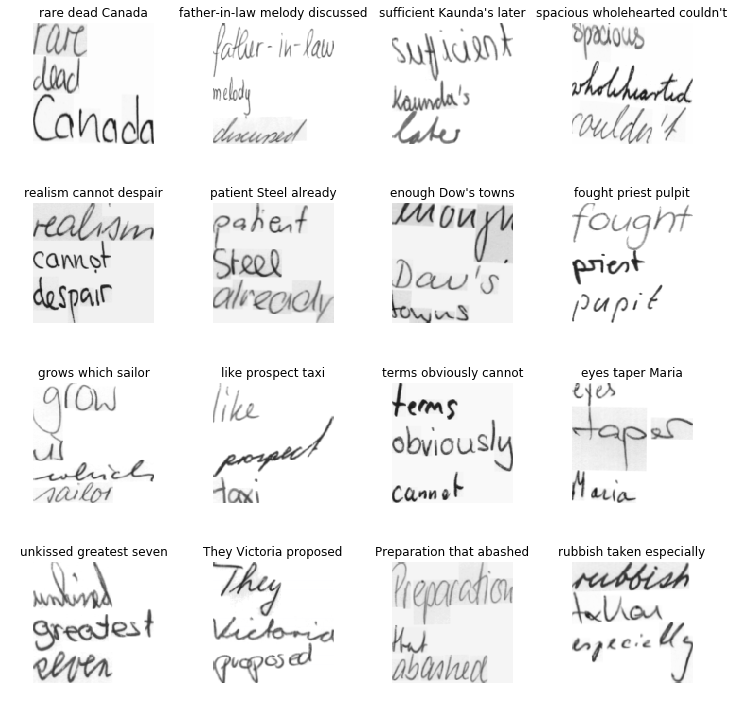

In [118]:
fig, axes = plt.subplots(4,4, figsize=(10, 10))
for i,ax in enumerate(axes.flat):
    t = label_text(y[i])
#     t = data.classes[y[i]]
    ax=show_img(x[i], ax=ax, title=t)
    
plt.tight_layout(pad=0.1)

# Loss fns

In [23]:
# categorical cross entropy loss
# list of probabilities for each word in vocab; target is correct word

def seq2seq_loss(input, target):
    target = target.permute(1,0).contiguous()
    tsl = target.size(0)
    sl,bs,nc = input.size()
    
    if sl>tsl: target = F.pad(target, (0,0,0,sl-tsl))
        
    targ = target.view(-1)
    pred = input.view(-1, nc)

    # combination of LogSoftmax and NLLLoss
    return F.cross_entropy(pred, targ.long(), reduction='sum')/bs

In [ ]:
ctc_loss = CTCLoss()
# ctc_loss = nn.CTCLoss()  #pytorch master branch (unreleased)

def custom_loss(input, target):
    bs,sl = target.size()      #=> ([bs, sl])
    _,sl_in,vs = input.size()  #=> ([bs, 4, 16, 80])
    inp = input.permute(1,0,2) #=> ([sl_in, bs, 80])
    
    inp_lens = torch.full((bs,), sl_in, dtype=torch.int32)
    
    ##NOTE: inp => gpu, everything else on cpu!!
    
    # need to remove 0s from labels (same as ctc blank character)
    targ = []
    targ_lens = []
    for i in range(bs):
        t = target[i,:]
        # remove 0 padding from targets
        t = t[t.nonzero().squeeze(1)]
        targ.append(t)
        targ_lens.append(len(t))

    targ = torch.cat(targ).type(torch.int32).cpu()
    targ_lens = torch.tensor(targ_lens, dtype=torch.int32)
    
#     targ = target.reshape(bs*sl).type(torch.int32)
#     targ_lens = torch.full((bs,), sl, device=device, dtype=torch.int32)
    
    return ctc_loss(inp, targ, inp_lens, targ_lens)    
    # inputs: Tensor of (seqLength x batch x vocab_size) containing output activations from network (before softmax)
    # targets: 1 dimensional Tensor containing all the targets of the batch in one large sequence
    # input_lens: Tensor of size (batch) containing size of each output sequence from the network
    # target_lens: Tensor of (batch) containing label length of each example

# Hybrid Arch

### Blocks

In [67]:
class ConvBlock(nn.Module):
    def __init__(self, ni, nh, drop=0.2, p=(2,2)):
        super().__init__()
        self.p = p
        
        self.drop = nn.Dropout(drop)
        self.conv = nn.Conv2d(ni*p[0]*p[1], nh, 3, padding=1)  #maintain size
        self.bn   = nn.BatchNorm2d(nh)
    
    def tile(self, x):
        bs, nf, h, w = x.size()   # Note: different order than ReNet tile!!!
        p_height = self.p[0]
        p_width  = self.p[1]

        assert h % p_height == 0
        assert w % p_width  == 0

        new_height = int(h / p_height)
        new_width  = int(w / p_width)

        x = x.view(bs, nf, new_height, p_height, new_width, p_width)
        x = x.permute(0, 1, 3, 5, 2, 4).contiguous()
        x = x.view(bs, nf * p_height * p_width, new_height, new_width)
        return x

    def forward(self, x):
        x = self.tile(x)
        x = self.bn(self.conv(self.drop(x)))
        x = F.leaky_relu(x)
        return x

In [63]:
class ReNetBlock(nn.Module):
    def __init__(self, ni, nh, drop=0.4, p=(2,1)):
        super(ReNetBlock, self).__init__()
        
        self.p_height = p[0]
        self.p_width = p[1]

        self.drop = nn.Dropout(drop)
        self.vrnn = nn.GRU(ni*self.p_height*self.p_width, nh, num_layers=1,
                           bias=True, batch_first=True, bidirectional=True)
        self.hrnn = nn.GRU(2*nh, nh, num_layers=1,
                           bias=True, batch_first=True, bidirectional=True)
    
    def tile(self, x):
        bs, h, w, nf = x.size()

        assert h % self.p_height == 0
        assert w % self.p_width  == 0

        new_height = int(h / self.p_height)
        new_width  = int(w / self.p_width)

        x = x.view(bs, new_height, self.p_height, new_width, self.p_width, nf)
        x = x.permute(0, 1, 3, 2, 4, 5).contiguous()
        x = x.view(bs, new_height, new_width, self.p_height * self.p_width * nf)
        return x
    
    def rnn_forward(self, x, hor_or_ver):
        assert hor_or_ver in ['hor', 'ver']
        bs, h, w, nf = x.size()

        x = x.view(bs*h, w, nf)
        if hor_or_ver == 'hor':
            x, _ = self.hrnn(x)
        else:
            x, _ = self.vrnn(x)
        x = x.contiguous()
        x = x.view(bs, h, w, -1)
        return x

    def forward(self, inp):
        x = self.tile(inp)                 #bs, h, w, nf
        x = self.drop(x)
        
        x = self.rnn_forward(x, 'ver')
        x = x.permute(0, 2, 1, 3)          #bs, w, h, nf
        x = x.contiguous()
        
        x = self.rnn_forward(x, 'hor')
        x = x.permute(0, 2, 1, 3)          #bs, h, w, nf
        x = x.contiguous()
        return x

### Original

In [ ]:
class Hybrid(nn.Module):
    def __init__(self, nh, vs):
        super().__init__()
        
        self.conv0 = nn.Conv2d(3, 16, 3, stride=1, padding=1)
           
        self.block1 = ReNetBlock(16, nh, p=(4,2))
        self.block2 = ReNetBlock(32, nh, p=(2,2))
        self.block3 = ReNetBlock(64, nh, p=(2,2))
        
        self.conv1 = ConvBlock(nh*2, 32, p=(2,1))
        self.conv2 = ConvBlock(nh*2, 64, p=(2,1))
        self.conv3 = ConvBlock(nh*2, 128, p=(2,1))
        
        self.drop = nn.Dropout(0.4)
        self.out = nn.Linear(128, vs)
        
    def forward(self, inp):
        #(bs, nf, h, w)
        
        x = self.conv0(inp)
        
        x = x.permute(0, 2, 3, 1) #bs, h, w, nf
        x = self.block1(x)
        x = x.permute(0, 3, 1, 2)
        x = self.conv1(x)
        
        x = x.permute(0, 2, 3, 1) #bs, h, w, nf
        x = self.block2(x)
        x = x.permute(0, 3, 1, 2)
        x = self.conv2(x)

        x = x.permute(0, 2, 3, 1) #bs, h, w, nf
        x = self.block3(x)
        x = x.permute(0, 3, 1, 2)
        x = self.conv3(x)

        x = x.permute(0, 2, 3, 1)
        x = self.drop(x)
        x = self.out(x)      #([30, 1, 16, 80])
        
        return x.squeeze(1)

In [ ]:
net = Hybrid(100, len(itos))
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))
learn = RNN_Learner(data, SingleModel(to_gpu(net)), opt_fn=opt_fn)
learn.crit = custom_loss
learn.clip = 10.
learn.metrics = [char_error_rate]

### Customized

In [71]:
class Encoder(nn.Module):
    def __init__(self, vs):
        super().__init__()
        nh = 100
        
        self.conv0 = nn.Conv2d(3, 16, 3, stride=1, padding=1)
           
        self.block1 = ReNetBlock(16, nh, p=(2,2))
        self.block2 = ReNetBlock(32, nh, p=(2,2))
        self.block3 = ReNetBlock(64, nh, p=(1,1))
        
        self.conv1 = ConvBlock(nh*2, 32, p=(2,2))
        self.conv2 = ConvBlock(nh*2, 64, p=(2,2))
        self.conv3 = ConvBlock(nh*2, 128, p=(1,1))
        
        self.drop = nn.Dropout(0.4)
        self.out = nn.GRU(128, vs, 1)
#         self.out = nn.Linear(128, vs)
        
    def forward(self, inp):
        #(bs, nf, h, w)
        
        x = self.conv0(inp)
        
        x = x.permute(0, 2, 3, 1) #bs, h, w, nf
        x = self.block1(x)
        x = x.permute(0, 3, 1, 2)
        x = self.conv1(x)
        
        x = x.permute(0, 2, 3, 1) #bs, h, w, nf
        x = self.block2(x)
        x = x.permute(0, 3, 1, 2)
        x = self.conv2(x)

        x = x.permute(0, 2, 3, 1) #bs, h, w, nf
        x = self.block3(x)
        x = x.permute(0, 3, 1, 2)
        x = self.conv3(x)

        x = x.permute(2, 3, 0, 1).flatten(0,1) #h*w,bs,nf
        x = self.drop(x)
        
        x = self.out(x)      #([bs, 1, 16, 80])
        
        return x

# Transpose/concat bidir encoder; attention decoder

In [24]:
class Encoder(nn.Module):
    def __init__(self, embed_size):
        super().__init__()
        
        self.hrnn = nn.GRU(embed_size, embed_size//2, 1, bidirectional=True)
        self.vrnn = nn.GRU(embed_size, embed_size//2, 1, bidirectional=True)
        self.rnn  = nn.GRU(embed_size*2, embed_size, 1)
        
    def forward(self, inp):
        bs,nf,h,w = inp.size()    #head => 8x8x256
        hor = torch.flatten(inp, 2,3)  
        outh,hh = self.hrnn(hor.permute(2, 0, 1))   #([64,30,256])
        
        # transpose input
        ver = torch.transpose(inp, 2,3).flatten(2,3)
        outv,hv = self.vrnn(ver.permute(2, 0, 1))
        # un-transpose rnn output
        outv = outv.reshape(w,h,bs,-1)
        outv = outv.transpose(1,0).flatten(0,1)
        # concat results
        out = torch.cat((outh, outv), -1)
        h = torch.cat((hh[-1], hv[-1]), -1)
                        
        return self.rnn(out, h.unsqueeze(0))

In [28]:
def rand_t(*sz): return torch.randn(sz)/math.sqrt(sz[0])
def rand_p(*sz): return nn.Parameter(rand_t(*sz))

class Seq2SeqRNN(nn.Module):
    def __init__(self, embed_size, vocab_size, num_layers, seq_len):
        super(Seq2SeqRNN, self).__init__()
        self.seq_len = seq_len
        
        head = Encoder(embed_size)
        self.encoder = ConvnetBuilder(f, 0, 0, 0, xtra_cut=1, custom_head=head).model

        self.dec_emb = nn.Embedding(vocab_size, embed_size)
        self.dec_rnn = nn.GRU(embed_size, embed_size, num_layers)
        self.dec_linear = nn.Linear(embed_size, vocab_size)
        
        # setting up Attention Layers
#         self.W1 = rand_p(embed_size, embed_size)
        self.attn_1 = nn.Linear(embed_size, embed_size)
        self.attn_2 = nn.Linear(embed_size, embed_size) 
        self.attn_3 = nn.Linear(embed_size*2, embed_size)
        self.attn_v = rand_p(embed_size)

    def forward(self, inp, ret_attn=False):        
        ### Encoder ###
        bs = inp.size(0)        
        out, h = self.encoder(inp)
                        
        ### Decoder ###
        dec_inp = torch.zeros(bs, device=device).long()
        
        res,attns = [],[]
        #w1e = out @ self.W1  #=> ([16, 30, 256])          # encoder hidden states
        w1e = self.attn_1(out)
        
        for i in range(self.seq_len):
            w2h = self.attn_2(h)  #=> ([1, 30, 256])          # current decoder hidden state
            u = torch.tanh(w1e + w2h) #=> ([16, 30, 256])
            a = torch.softmax(u @ self.attn_v, 0)  #=> ([16, 30])    # attention mask
            attns.append(a)

            # weighted sum of all of the encoder outputs w/ attention results
            Xa = (a.unsqueeze(2) * out).sum(0) #=> ([30, 256])

            emb = self.dec_emb(dec_inp)    # embedding => ([30, 256])
                     
            # concatenated w/ current decoder hidden...  -> paper version
#             wgt_h = self.attn_3(torch.cat([Xa.unsqueeze(0),h], 2)) #=> ([1, 30, 256])
#             outp, h = self.dec_rnn(emb.unsqueeze(0), wgt_h)
            
            # concatenated w/ embeddings and fed as input...  -> jeremy's version
            wgt_enc = self.attn_3(torch.cat([emb, Xa], 1)) #=> ([30, 256])
            outp, h = self.dec_rnn(wgt_enc.unsqueeze(0), h)

            outp = self.dec_linear(outp[0])           # linear layer => ([30, 81])
            res.append(outp)
            dec_inp = outp.data.max(1)[1]          # predictions => ([30])
            
        res = torch.stack(res)
        if ret_attn: res = res,torch.stack(attns)
        return res

## Vanilla decoder

In [61]:
class Seq2SeqRNN(nn.Module):
    def __init__(self, embed_size, vocab_size, num_layers, seq_len):
        super(Seq2SeqRNN, self).__init__()
        self.seq_len = seq_len
        
        head = Encoder(embed_size)
        self.encoder = ConvnetBuilder(f, 0, 0, 0, xtra_cut=1, custom_head=head).model

        self.dec_emb = nn.Embedding(vocab_size, embed_size)
        self.dec_rnn = nn.GRU(embed_size, embed_size, num_layers)
        self.dec_linear = nn.Linear(embed_size, vocab_size)

    def forward(self, inp):        
        ### Encoder ###
        bs = inp.size(0)        
        out, h = self.encoder(inp)
                        
        ### Decoder ###
        dec_inp = torch.zeros(bs, device=device).long()
        
        res = []
        for i in range(self.seq_len):
            emb = self.dec_emb(dec_inp)    # embedding => ([30, 256])
            outp, h = self.dec_rnn(emb.unsqueeze(0), h)

            outp = self.dec_linear(outp[0])           # linear layer => ([30, 81])
            res.append(outp)
            dec_inp = outp.data.max(1)[1]          # predictions => ([30])
            
        res = torch.stack(res)
        return res

## LR find

 69%|██████▉   | 196/284 [00:32<00:14,  6.09it/s, loss=229] 

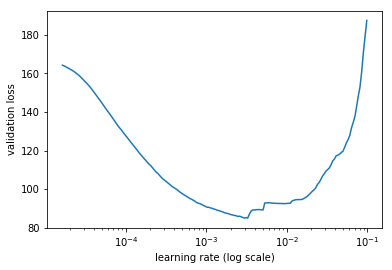

In [30]:
learn.lr_find()
learn.sched.plot()

## Train

In [64]:
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))
rnn = Seq2SeqRNN(256, len(itos), 1, 40)
learn = RNN_Learner(data, SingleModel(to_gpu(rnn)), opt_fn=opt_fn)
learn.clip = 0.25
learn.crit = seq2seq_loss

In [65]:
lr=1e-4
learn.fit(lr, 1, cycle_len=1)

#1000, bs:30, sz: 128, num_layers: 2, lr:7e-4
#em_sz:256                  97.668887  60.525838    2min
#em_sz:512                  77.904193  55.977164    2min
# "", no weight tying       80.588569  55.99028     2min
# "", "", w/ encoder STN    121.339167 56.856693    2.25min
# "", "", renet/conv 4x4    70.269559  54.043423    2.5min    **
# "", "", renet/conv 8x8    84.064616  55.46244     3.1min

#em_sz:256, num_layers:1
#flatten->rnn_encoder,attn (input)   71.984349  55.902448     -> 75.9 (75.6 w/ grad clipping, 73.9, 73.5)
#                      alt (hidden)  80.700541  66.80391      -> matches paper...  90.4,88.99,86.2
# transposed/concatenated                                     -> 74.978793

# GPU
#10000, lr:1e-4
# trans/cat enc, attn       69.061411  67.957871              -> 61.525784  61.807825 (**11cycles)
# "", vanilla decoder       69.462132  68.390057

  0%|          | 0/284 [00:00<?, ?it/s]

ValueError: too many values to unpack (expected 2)

In [35]:
learn.save('1cycle')

### Continue training

In [36]:
learn.fit(lr, 1, cycle_len=5, use_clr=(10,4))

epoch      trn_loss   val_loss                              
    0      68.073755  67.260952 
    1      66.726001  66.056838                             
    2      65.222971  65.651269                             
    3      64.853387  63.977445                             
    4      63.763634  63.656874                             


[63.656874389648436]

In [37]:
learn.save('6cycle')

In [49]:
learn.fit(lr, 1, cycle_len=5, use_clr=(10,4))

epoch      trn_loss   val_loss                              
    0      63.919463  65.78036  
    1      63.583184  63.95676                              
    2      62.884559  62.695055                             
    3      62.246516  62.243178                             
    4      61.525784  61.807825                             


[61.80782493591309]

In [50]:
learn.save('11cycle')

# Custom2

In [22]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
        # when the forward method of this module (m) is called it will call self.hook_fn
    def hook_fn(self, module, input, output): self.features = output
        # stores output in the features attribute
    def close(self): self.hook.remove()
        
        
class Encoder(nn.Module):
    def __init__(self, embed_size):
        super().__init__()
        
        self.base = ConvnetBuilder(f, embed_size, 0, 0, xtra_cut=1).model   #([30,256,8,8])
#         self.base = ConvnetBuilder(f, embed_size, 0, 0).model               #([30,512,4,4])
        self.grid = SaveFeatures(children(self.base)[-11])  

    def forward(self, inp):
        h = self.base(inp)
        
        feats = self.grid.features
        feats = torch.flatten(feats, 2,3)
        feats = feats.permute(2,0,1)
        
        return feats, h

In [10]:
def rand_t(*sz): return torch.randn(sz)/math.sqrt(sz[0])
def rand_p(*sz): return nn.Parameter(rand_t(*sz))

class Seq2SeqRNN(nn.Module):
    def __init__(self, embed_size, vocab_size, num_layers, seq_len):
        super(Seq2SeqRNN, self).__init__()
        self.num_layers = num_layers
        self.seq_len = seq_len
        
        self.encoder = Encoder(embed_size)

        self.dec_emb = nn.Embedding(vocab_size, embed_size)
        self.dec_rnn = nn.GRU(embed_size, embed_size, num_layers)
        self.dec_linear = nn.Linear(embed_size, vocab_size)
        
        # setting up Attention Layers
        self.W1 = rand_p(embed_size, embed_size)
#         self.W1 = nn.Conv2d(embed_size, embed_size, 2)
        self.l2 = nn.Linear(embed_size, embed_size) 
        self.l3 = nn.Linear(embed_size+embed_size, embed_size)
        self.V  = rand_p(embed_size)

    def forward(self, inp):        
        ### Encoder ###
        bs = inp.size(0)        
        out, h = self.encoder(inp)         #([30, 4, 4, 256])
        #h = torch.stack((h,h))          #(2, 30, 256)   # 2 layers
                
        ### Decoder ###
        dec_inp = V(torch.zeros(bs).long())
        
        res,attns = [],[]
        
        
        w1e = out @ self.W1  #=> ([16, 30, 256])

        for i in range(self.seq_len):
            # take current hidden state of decoder and put it into a linear layer
            w2h = self.l2(h[-1])  #=> ([1, 30, 256])
            # non-linear activation
            u = torch.tanh(w1e + w2h) #=> ([16, 30, 256])
            # matrix multiply; softmax ensures all weights add up to 1 and 1 is higher than the rest
            a = torch.softmax(u @ self.V, 0)  #=> ([16, 30])
            attns.append(a)
            # a.unsqueeze(2): add axis at index 2 => ([16, 30, 1])
            # weighted sum of all of the encoder outputs w/ attention results
            Xa = (a.unsqueeze(2) * out).sum(0) #=> ([30, 256])

            emb = self.dec_emb(dec_inp)    # embedding => ([30, 256])
            
            wgt_enc = self.l3(torch.cat([emb, Xa], 1)) #=> ([30, 256])
            outp, h = self.dec_rnn(wgt_enc.unsqueeze(0), h)
            
            

#         res = []
#         for i in range(self.seq_len):
#             emb = self.dec_emb(dec_inp).unsqueeze(0)  # embedding => ([1, 30, 256])
#             outp, h = self.dec_rnn(emb, h)            # rnn => ([1, 30, 256]),  ([2, 30, 256])
            outp = self.dec_linear(outp[0])           # linear layer => ([30, 81])
            res.append(outp)
            dec_inp = V(outp.data.max(1)[1])          # predictions => ([30])
        return torch.stack(res)

In [104]:
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))
rnn = Seq2SeqRNN(256, len(itos), 1, 35)
learn = RNN_Learner(data, SingleModel(to_gpu(rnn)), opt_fn=opt_fn)
learn.crit = seq2seq_loss

In [105]:
lr=7e-4
learn.fit(lr, 1, cycle_len=1)

#1000, bs:30, sz: 128, num_layers: 2, lr:7e-4
#em_sz:256                  97.668887  60.525838    2min
#em_sz:512                  77.904193  55.977164    2min
# "", no weight tying       80.588569  55.99028     2min
# "", "", w/ encoder STN    121.339167 56.856693    2.25min
# "", "", renet/conv 4x4    70.269559  54.043423    2.5min    **
# "", "", renet/conv 8x8    84.064616  55.46244     3.1min

# ConvnetBuilder(f, embed_size, 0, 0)   77.697741  55.164891  t_____
# ConvnetBuilder(f, embed_size, 1, 1)   81.846109  59.502135  e_____
# ConvnetBuilder(f, embed_size, 0, 1)   93.810281  62.048532  ____ee

# "", attn

#10000, lr:7e-4              50.689892  49.319883    20min
# w/ STN before encoder      

epoch      trn_loss   val_loss                           
    0      101.764574 55.0019   


[55.00189971923828]

In [108]:
learn.fit(lr, 1, cycle_len=5, use_clr=(10,5))

epoch      trn_loss   val_loss                            
    0      55.233789  55.212958 
    1      55.222451  59.196336                           
    2      54.200469  53.966232                           
    3      53.484065  54.255312                           
    4      53.075202  53.56874                            


[53.56874008178711]

# Seq2seq (translation)

In [123]:
class Seq2SeqRNN(nn.Module):
    def __init__(self, embed_size, vocab_size, num_layers, seq_len):
        super(Seq2SeqRNN, self).__init__()
        self.num_layers = num_layers
        self.seq_len = seq_len
        
        self.encoder = ConvnetBuilder(f, embed_size, True, True).model

        self.dec_emb = nn.Embedding(vocab_size, embed_size)
        self.dec_rnn = nn.GRU(embed_size, embed_size, num_layers)
        self.dec_linear = nn.Linear(embed_size, vocab_size)
        #self.init_weights()

    def init_weights(self):
        self.dec_emb.weight.data.uniform_(-0.1, 0.1)
        self.dec_linear.weight.data = self.dec_emb.weight.data  #weight tying??
        self.dec_linear.bias.data.fill_(0)
        
    def forward(self, inp):        
        ### Encoder ###
        bs = inp.size(0)
        enc = self.encoder(inp)         #([30, 256])
        h = enc.unsqueeze(0) #torch.stack((enc,enc)) 

        ### Decoder ###
        dec_inp = V(torch.zeros(bs).long())
        res = []
        for i in range(self.seq_len):
            emb = self.dec_emb(dec_inp).unsqueeze(0)  # embedding => ([1, 30, 256])
            outp, h = self.dec_rnn(emb, h)            # rnn => ([1, 30, 256]),  ([2, 30, 256])
            #1 layer:  outp == h
            #2 layers: outp == h[-1]
            outp = self.dec_linear(outp[0])           # linear layer => ([30, 81])
            res.append(outp)
            dec_inp = V(outp.data.max(1)[1])  #=> ([125])
        return torch.stack(res)                       # ([35, 30, 81])

In [124]:
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))
rnn = Seq2SeqRNN(512, len(itos), 1, 35)
learn = RNN_Learner(data, SingleModel(to_gpu(rnn)), opt_fn=opt_fn)
learn.clip = 0.25
learn.crit = seq2seq_loss

In [125]:
lr=7e-4
learn.fit(lr, 1, cycle_len=1)

#1000, bs:30, sz: 128, num_layers: 2, lr:7e-4
#em_sz:256                  97.668887  60.525838    2min
#em_sz:512                  77.904193  55.977164    2min
# "", num_layers: 1         84.144111  60.642912    2min
# "", no weight tying       80.588569  55.99028     2min
# "", "", w/ encoder STN    121.339167 56.856693    2.25min

#10000, lr:7e-4              50.689892  49.319883    20min
# w/ STN before encoder      

epoch      trn_loss   val_loss                            
    0      84.144111  60.642912 


[60.64291229248047]

# Attention

In [66]:
class Encoder(nn.Module):
    def __init__(self, nh):
        super().__init__()
        
        #head => 8x8x256
        self.block1 = ReNetBlock(256, nh, p=(2,2))
        
        self.drop = nn.Dropout(0.4)
        self.out = nn.Linear(nh*2, nh)
        
    def forward(self, inp):
        #(bs, nf, h, w)
        x = inp  #head => 8x8x256
        
        x = x.permute(0, 2, 3, 1) #bs, h, w, nf
        x = self.block1(x)

        x = self.drop(x)
        x = self.out(x)      #([bs, 4, 4, vs])
        
        return 0, x

In [239]:
def rand_t(*sz): return torch.randn(sz)/math.sqrt(sz[0])
def rand_p(*sz): return nn.Parameter(rand_t(*sz))

class Seq2SeqRNN(nn.Module):
    def __init__(self, embed_size, vocab_size, num_layers, seq_len):
        super(Seq2SeqRNN, self).__init__()
        self.num_layers = num_layers
        self.seq_len = seq_len
        
        head = Encoder(embed_size)
        self.encoder = ConvnetBuilder(f, 0, 0, 0, xtra_cut=1, custom_head=head).model
        
        self.conv = nn.Conv2d(embed_size, embed_size, 4)

        self.dec_emb = nn.Embedding(vocab_size, embed_size)
        self.dec_rnn = nn.GRU(embed_size, embed_size, num_layers)
        self.dec_linear = nn.Linear(embed_size, vocab_size)

        # setting up Attention Layers
        self.W1 = rand_p(embed_size, embed_size)
        self.l2 = nn.Linear(embed_size, embed_size) 
        self.l3 = nn.Linear(embed_size+embed_size, embed_size)
        self.V  = rand_p(embed_size)
        
    def forward(self, inp, y=None):        
        ### Encoder ###
        bs = inp.size(0)
        enc = self.encoder(inp)         #([30, 4, 4, 256])
        
        out = enc.permute(1,2,0,3)
        out = torch.flatten(out, 0,1)   #(16, 30, 256)
    
        h = enc.permute(0,3,1,2)
        h = self.conv(h).squeeze()      #(30, 256)
        h = torch.stack((h,h))          #(2, 30, 256)   # 2 layers
                
        ### Decoder ###
        dec_inp = V(torch.zeros(bs).long())
        

        res,attns = [],[]
        w1e = out @ self.W1  #=> ([16, 30, 256])

        for i in range(self.seq_len):
            # take current hidden state of decoder and put it into a linear layer
            w2h = self.l2(h[-1])  #=> ([1, 30, 256])
            # non-linear activation
            u = torch.tanh(w1e + w2h) #=> ([16, 30, 256])
            # matrix multiply; softmax ensures all weights add up to 1 and 1 is higher than the rest
            a = torch.softmax(u @ self.V, 0)  #=> ([16, 30])
            attns.append(a)
            # a.unsqueeze(2): add axis at index 2 => ([16, 30, 1])
            # weighted sum of all of the encoder outputs w/ attention results
            Xa = (a.unsqueeze(2) * out).sum(0) #=> ([30, 256])

            emb = self.dec_emb(dec_inp)    # embedding => ([30, 256])
            
            wgt_enc = self.l3(torch.cat([emb, Xa], 1)) #=> ([30, 256])
            outp, h = self.dec_rnn(wgt_enc.unsqueeze(0), h)
            
            
#         res = []
#         for i in range(self.seq_len):
#             emb = self.dec_emb(dec_inp).unsqueeze(0)  # embedding => ([1, 30, 256])
#             outp, h = self.dec_rnn(emb, h)            # rnn => ([1, 30, 256]),  ([2, 30, 256])
            outp = self.dec_linear(outp[0])           # linear layer => ([30, 81])
            res.append(outp)
            dec_inp = V(outp.data.max(1)[1])          # predictions => ([30])
            
            ## teacher forcing section ##
            if (y is not None) and (random.random()<self.pr_force):
                if i>=y.size(1): break
                dec_inp = y[:,i].long()

        return torch.stack(res)

In [214]:
class Seq2SeqStepper(Stepper):
    def step(self, xs, y, epoch):
        self.m.pr_force = (5-epoch)*0.2 if epoch<5 else 0

        xtra = []
        output = self.m(*xs, y) # calls the .forward() method here passing in the y
        if isinstance(output,tuple): output,*xtra = output
        self.opt.zero_grad()
        loss = raw_loss = self.crit(output, y)
        if self.reg_fn: loss = self.reg_fn(output, xtra, raw_loss)
        loss.backward()
        if self.clip:   # Gradient clipping
            nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)
        self.opt.step()
        return raw_loss.data.item()

In [240]:
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))
rnn = Seq2SeqRNN(512, len(itos), 2, 35)
learn = RNN_Learner(data, SingleModel(to_gpu(rnn)), opt_fn=opt_fn)
learn.crit = seq2seq_loss

In [241]:
lr=7e-4
learn.fit(lr, 1, cycle_len=1)#, stepper=Seq2SeqStepper)

#1000, bs:30, sz: 128, num_layers: 2, lr:7e-4
#em_sz:256                  97.668887  60.525838    2min
#em_sz:512                  77.904193  55.977164    2min
# "", no weight tying       80.588569  55.99028     2min
# "", "", w/ encoder STN    121.339167 56.856693    2.25min
# "", "", renet/conv 4x4    70.269559  54.043423    2.5min
# "", "", "", attn          70.791891  53.568365    3min      **
# "", "", "", "", tforcing  56.163932  63.598125    2.75min
# "", "", re/conv 8x8, attn 76.967266  54.308807    4.25min

#10000, lr:7e-4              50.689892  49.319883    20min
# w/ STN before encoder      

epoch      trn_loss   val_loss                            
    0      76.967266  54.308807 


[54.308807373046875]

In [180]:
learn.save('1cycle')

# Sanity Check

## Gradients

In [38]:
def is_bad_grad(grad_output):
    grad_output = grad_output.data
    return grad_output.ne(grad_output).any() or grad_output.gt(1e6).any()

In [39]:
def is_zero_grad(grad_output):
    grad_output = grad_output.data
    return grad_output.eq(0.0).all()

In [40]:
params = list(learn.model.named_parameters())

p_hash = {}
p_grad = {}
for k,v in params:
    p_hash[k] = v
    p_grad[k] = v.grad
# [p.grad for p in learn.model.parameters()]

In [41]:
for i in list(p_grad.values()):
    if is_bad_grad(i): print('bad')
    if is_zero_grad(i): print('zero')

## Outputs

In [58]:
x,y = next(iter(data.val_dl))
learn.model.eval()
preds,attns = learn.model(x, ret_attn=True)
#attns ([sl, 64, bs])
res = torch.argmax(preds, dim=-1)

In [52]:
seq2seq_loss(preds, y)

tensor(56.7443, device='cuda:0', grad_fn=<DivBackward0>)

In [59]:
for i in range(10):
    print(label_text(res[:,i]))

teee          e
eeeee          eeeeeeee
eeee           e
eeeee          eeeee
teee          e
teee          
teeee         eeeeeee
teeee         ee
eeeee          eeeee
eeeee          eeee


In [45]:
def label_text(pred):
    ints = to_np(pred).astype(int)
    ints = np.trim_zeros(ints)   # remove padding (0)
    return ''.join([itos[i] for i in ints])

## Images

In [148]:
def show_img(im, figsize=None, ax=None, alpha=None, title=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, alpha=alpha)
    ax.set_axis_off()
    if title: ax.set_title(title)
    return ax

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


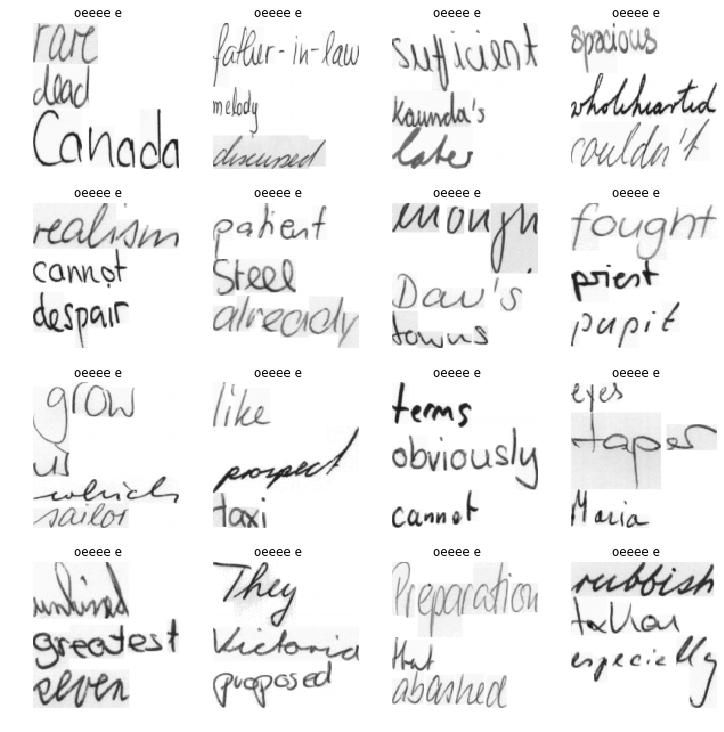

In [356]:
im = data.trn_ds.denorm(x)

fig, axes = plt.subplots(4,4, figsize=(10, 10))
for i,ax in enumerate(axes.flat):
    t = label_text(y[i])     #=>  char indices
    p = label_text(res[:,i])
    ax=show_img(im[i], ax=ax, title=p)#t+' '+p)
    
plt.tight_layout(pad=0.1)

## Attention Visualization

In [54]:
attn = to_np(attns[:,:,0])  # first batch

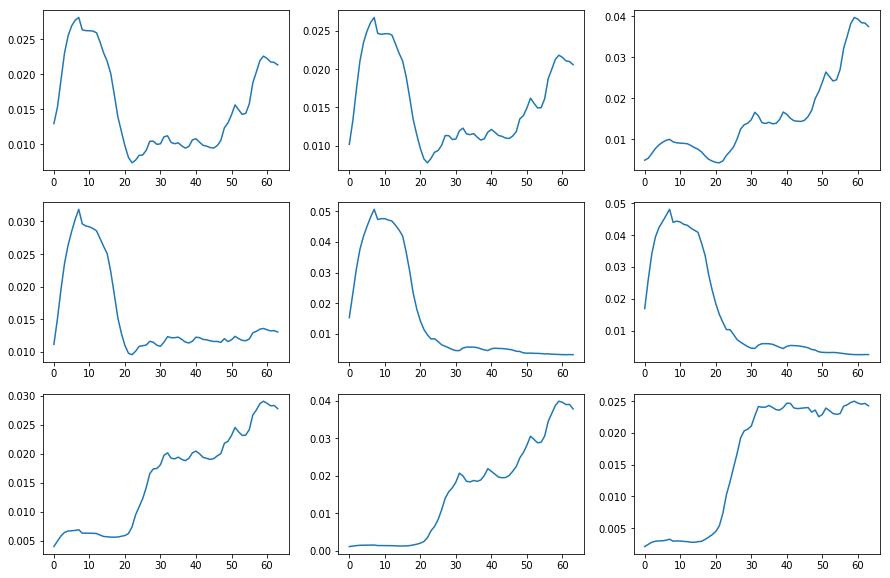

In [55]:
fig, axes = plt.subplots(3, 3, figsize=(15, 10))
for i,ax in enumerate(axes.flat):
    ax.plot(attn[i])

# Show, Attend, Tell
https://github.com/parksunwoo/show_attend_and_tell_pytorch/blob/master/model.py

In [ ]:
class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        super(EncoderCNN, self).__init__()
        vggnet = torchvision.models.vgg19(pretrained=True)
        modules = list(vggnet.children())[:-1]
        self.vggnet = nn.Sequential(*modules)
        self.linear = nn.Linear(vggnet.classifier[6].in_features, embed_size)
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)
        self.init_weights()

    def init_weights(self):
        self.linear.weight.data.normal_(0.0, 0.2)
        self.linear.bias.data.fill_(0)

    def forward(self, images):
        features = self.vggnet(images)
        features = Variable(features.data)
        print (features)
        features = features.view(features.size(0), -1)
        features = self.bn(self.linear(features))
        return features


class AttnDecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.embed = nn.Embedding(vocab_size, embed_size)
        self.attn = nn.Linear(hidden_size, hidden_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.init_weights()

    def init_weights(self):
        self.embed.weight.data.uniform_(-0.1, 0.1)
        self.linear.weight.data.uniform_(-0.1, 0.1)
        self.linear.bias.data.fill_(0)

    def init_hidden(self):
        return cuda_variable(torch.zeros(self.num_layers, 1, self.hidden_size))

    def forward(self, captions, last_hidden, encoder_hiddens, lengths):
        embeddings = self.embed(captions)
        embeddings = torch.cat((last_hidden.unsqueeze(1), embeddings), 1)
        packed = torch.nn.utils.rnn.pack_padded_sequence(embeddings, lengths, batch_first=True)
        hiddens, _ = self.lstm(packed)
        rnn_output = self.linear(hiddens[0])
        print (rnn_output)

        attn_weights = self._get_att_weight(rnn_output.squeeze(0), encoder_hiddens)
        context = attn_weights.bmm(encoder_hiddens.transpose(0,1))

        rnn_output = rnn_output.squeeze(0)
        context = context.squeeze(1)
        output = self.out(torch.cat((rnn_output, context), 1))

        return output

    def _get_att_weight(self, hidden, encoder_hiddens):
        seq_len = len(encoder_hiddens)

        # Create variable to store attention energies
        attn_scores = cuda_variable(torch.zeros(seq_len))  # B x 1 x S

        # Calculate energies for each encoder hidden
        for i in range(seq_len):
            attn_scores[i] = self.get_att_score(hidden, encoder_hiddens[i])

        # Normalize scores to weights in range 0 to 1,
        # resize to 1 x 1 x seq_len
        # print("att_scores", attn_scores.size())
        return nn.softmax(attn_scores).view(1, 1, -1)


    def get_att_score(self, hidden, encoder_hidden):
        score = self.attn(encoder_hidden)
        return torch.dot(hidden.view(-1), score.view(-1))


def cuda_variable(tensor):
    if torch.cuda.is_available():
        return Variable(tensor.cuda())
    else:
        return Variable(tensor)

In [ ]:
def main(args):
    transform = transforms.Compose([
        transforms.RandomCrop(args.crop_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406),
                             (0.229, 0.224,
                              0.225))
    ])

    data_loader = get_loader(args.image_dir, args.caption_path, vocab, transform, 128,
                             shuffle=True, num_workers=2)

    encoder = EncoderCNN(256)
    decoder = AttnDecoderRNN(256, 512, len(vocab), 1)

    if torch.cuda.is_available():
        encoder.cuda()
        decoder.cuda()

    criterion = nn.CrossEntropyLoss()
    params = list(decoder.parameters()) + list(encoder.linear.parameters()) + list(encoder.bn.parameters())
    optimizer = torch.optim.Adam(params, lr=1e-3)

    total_step = len(data_loader)
    decoder_hidden = decoder.init_hidden()

    for epoch in range(5):
        for i, (images, captions, lengths) in enumerate(data_loader):

            images = cuda_variable(images, volatile=True)
            captions = cuda_variable(captions)
            targets = pack_padded_sequence(captions, lengths, batch_first=True)[0]

            decoder.zero_grad()
            encoder.zero_grad()
            features = encoder(images)

            outputs = decoder(captions, decoder_hidden, features, lengths)
            # outputs = decoder(features, captions, lengths)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

# Combo

In [ ]:
class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers, max_seq_length=20):
        """Set the hyper-parameters and build the layers."""
        super(DecoderRNN, self).__init__()
        self.max_seq_length = max_seq_length

        *self.attn = nn.Linear(hidden_size, hidden_size)
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)
        
    def forward(self, features, captions, lengths):
        """Decode image feature vectors and generates captions."""
        embeddings = self.embed(captions)
        embeddings = torch.cat((features.unsqueeze(1), embeddings), 1)
        packed = torch.nn.utils.rnn.pack_padded_sequence(embeddings, lengths, batch_first=True) 
        hiddens, _ = self.lstm(packed)
        outputs = self.linear(hiddens[0])
        #return outputs

        *attn_weights = self.get_attn_weights(outputs.squeeze(0), features)
        *context = attn_weights.bmm(features.transpose(0,1))

        *result = self.out(torch.cat((outputs.squeeze(0), context.squeeze(1)), 1))
        *return result

    *def get_attn_weights(self, hidden, features):
        seq_len = len(features)

        # Create variable to store attention energies
        attn_scores = V(torch.zeros(seq_len))  # B x 1 x S

        # Calculate energies for each encoder hidden
        for i in range(self.seq_len):
            score = self.attn(features)
            attn_scores[i] = torch.dot(hidden.view(-1), score.view(-1))

        # Normalize scores to weights in range 0 to 1,
        # resize to 1 x 1 x seq_len
        # print("att_scores", attn_scores.size())
        return nn.softmax(attn_scores).view(1, 1, -1)

    
    def sample(self, features, states=None):
        """Generate captions for given image features using greedy search."""
        sampled_ids = []
        inputs = features.unsqueeze(1)
        for i in range(self.max_seg_length):
            hiddens, states = self.lstm(inputs, states)          # hiddens: (batch_size, 1, hidden_size)
            outputs = self.linear(hiddens.squeeze(1))            # outputs:  (batch_size, vocab_size)
            _, predicted = outputs.max(1)                        # predicted: (batch_size)
            sampled_ids.append(predicted)
            inputs = self.embed(predicted)                       # inputs: (batch_size, embed_size)
            inputs = inputs.unsqueeze(1)                         # inputs: (batch_size, 1, embed_size)
        sampled_ids = torch.stack(sampled_ids, 1)                # sampled_ids: (batch_size, max_seq_length)
        return sampled_ids

# Image Captioning
https://github.com/yunjey/pytorch-tutorial/tree/master/tutorials/03-advanced/image_captioning

In [ ]:
class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        """Load the pretrained ResNet-152 and replace top fc layer."""
        super(EncoderCNN, self).__init__()
        resnet = torchvision.models.resnet152(pretrained=True)
        modules = list(resnet.children())[:-1]      # without the last fc layer.
        self.resnet = nn.Sequential(*modules)
        self.linear = nn.Linear(resnet.fc.in_features, embed_size)
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)
        
    def forward(self, images):
        """Extract feature vectors from input images."""
        with torch.no_grad():
            features = self.resnet(images)
        features = features.reshape(features.size(0), -1)
        features = self.bn(self.linear(features))
        return features


class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers, max_seq_length=20):
        """Set the hyper-parameters and build the layers."""
        super(DecoderRNN, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.max_seq_length = max_seq_length
        
    def forward(self, features, captions, lengths):
        """Decode image feature vectors and generates captions."""
        embeddings = self.embed(captions)
        embeddings = torch.cat((features.unsqueeze(1), embeddings), 1)
        packed = torch.nn.utils.rnn.pack_padded_sequence(embeddings, lengths, batch_first=True) 
        hiddens, _ = self.lstm(packed)
        outputs = self.linear(hiddens[0])
        return outputs
    
    def sample(self, features, states=None):
        """Generate captions for given image features using greedy search."""
        sampled_ids = []
        inputs = features.unsqueeze(1)
        for i in range(self.max_seq_length):
            hiddens, states = self.lstm(inputs, states)          # hiddens: (batch_size, 1, hidden_size)
            outputs = self.linear(hiddens.squeeze(1))            # outputs:  (batch_size, vocab_size)
            _, predicted = outputs.max(1)                        # predicted: (batch_size)
            sampled_ids.append(predicted)
            inputs = self.embed(predicted)                       # inputs: (batch_size, embed_size)
            inputs = inputs.unsqueeze(1)                         # inputs: (batch_size, 1, embed_size)
        sampled_ids = torch.stack(sampled_ids, 1)                # sampled_ids: (batch_size, max_seq_length)
        return sampled_ids

In [ ]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def train(args):
    
    # Image preprocessing, normalization for the pretrained resnet
    transform = transforms.Compose([ 
        transforms.RandomCrop(args.crop_size),
        transforms.RandomHorizontalFlip(), 
        transforms.ToTensor(), 
        transforms.Normalize((0.485, 0.456, 0.406), 
                             (0.229, 0.224, 0.225))])
    
    # Build data loader
    data_loader = get_loader(args.image_dir, args.caption_path, vocab, 
                             transform, 128, shuffle=True, num_workers=2) 

    # Build the models
    encoder = EncoderCNN(256).to(device)
    decoder = DecoderRNN(256, 512, len(vocab), 1).to(device)
    
    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    params = list(decoder.parameters()) + list(encoder.linear.parameters()) + list(encoder.bn.parameters())
    optimizer = torch.optim.Adam(params, lr=1e-3)
    
    # Train the models
    total_step = len(data_loader)
    for epoch in range(5):
        for i, (images, captions, lengths) in enumerate(data_loader):
            
            # Set mini-batch dataset
            images = images.to(device)
            captions = captions.to(device)
            targets = pack_padded_sequence(captions, lengths, batch_first=True)[0]
            
            # Forward, backward and optimize
            features = encoder(images)
            outputs = decoder(features, captions, lengths)
            loss = criterion(outputs, targets)
            decoder.zero_grad()
            encoder.zero_grad()
            loss.backward()
            optimizer.step()

In [ ]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def load_image(image_path, transform=None):
    image = Image.open(image_path)
    image = image.resize([224, 224], Image.LANCZOS)
    
    if transform is not None:
        image = transform(image).unsqueeze(0)
    
    return image

def sample(args):
    # Image preprocessing
    transform = transforms.Compose([
        transforms.ToTensor(), 
        transforms.Normalize((0.485, 0.456, 0.406), 
                             (0.229, 0.224, 0.225))])
    
    # Load vocabulary wrapper
    with open(args.vocab_path, 'rb') as f:
        vocab = pickle.load(f)

    # Build models
    encoder = EncoderCNN(256).eval()  # eval mode (batchnorm uses moving mean/variance)
    decoder = DecoderRNN(256, 512, len(vocab), 1)
    encoder = encoder.to(device)
    decoder = decoder.to(device)

    # Load the trained model parameters
    encoder.load_state_dict(torch.load(args.encoder_path))
    decoder.load_state_dict(torch.load(args.decoder_path))

    # Prepare an image
    image = load_image(args.image, transform)
    image_tensor = image.to(device)
    
    # Generate an caption from the image
    feature = encoder(image_tensor)
    sampled_ids = decoder.sample(feature)
    sampled_ids = sampled_ids[0].cpu().numpy()          # (1, max_seq_length) -> (max_seq_length)
    
    # Convert word_ids to words
    sampled_caption = []
    for word_id in sampled_ids:
        word = vocab.idx2word[word_id]
        sampled_caption.append(word)
        if word == '<end>':
            break
    sentence = ' '.join(sampled_caption)
    
    # Print out the image and the generated caption
    print (sentence)
    image = Image.open(args.image)
    plt.imshow(np.asarray(image))